In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location' ]

In [7]:
numerical = [ 'number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score',
       'converted']

In [8]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values


del df_train['converted']
del df_val['converted']
del df_test['converted']

In [14]:
from sklearn.metrics import roc_auc_score
auc_scores = {}

numerical = [ 'number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']

for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    
    auc_scores[n] = auc

sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_auc:
     print(f"{feature}: {score:.4f}")

print("\nHighest AUC feature:", sorted_auc[0][0])

number_of_courses_viewed: 0.7636
interaction_count: 0.7383
lead_score: 0.6145
annual_income: 0.5520

Highest AUC feature: number_of_courses_viewed


In [15]:

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')


X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [18]:
y_pred = model.predict_proba(X_val)[:,1]
val_auc = roc_auc_score(y_val, y_pred)
print(round(val_auc, 3))

0.817


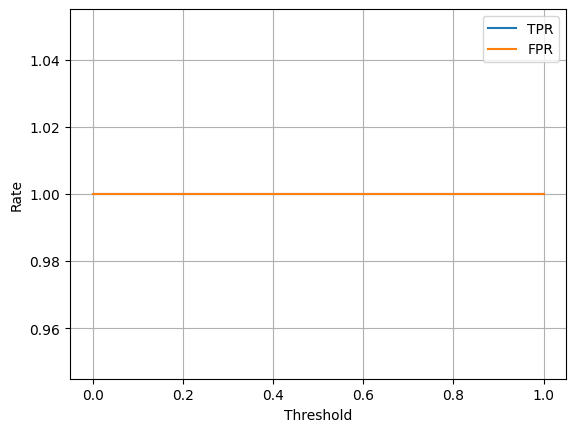

In [35]:

scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    preds = (y_pred_val_calibrated >= t)
    P = precision_score(y_val, preds)
    R = recall_score(y_val, preds)
    f1 = 0 if P + R == 0 else 2 * P * R / (P + R)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold by F1:", best_threshold)


Best threshold by F1: 0.45


C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [49]:

dv, model = train(df_train, y_train, C=0.001)

In [50]:

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [51]:

y_pred = predict(df_val, dv, model)

In [57]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

n_splits = 5
C = 1.0  # use only C=1.0

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C=1.0 0.919 +- 0.011


C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
from sklearn.model_selection import KFold

from tqdm.auto import tqdm


n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561 +- 0.024
C=0.001 0.868 +- 0.019


C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C=1 0.919 +- 0.011


C:\Users\Piyush Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
